In [1]:
import pandas as pd
import csv
import string
from string import digits
import numpy as np

In [2]:
import nltk

## BMW Topic Modeling

In [3]:
df=pd.read_csv("BMW.csv",sep=",")
df.head()

,comment,comment_id,post_id,post_time,post_title,time
0,"Roughly 175mph, as calculated by my USDM calcu...",epkhm04,bv2drs,1.559272e+09,Hit this in the M3 just cruising,2019-05-31 03:49:09
1,It's ok if you don't value your own life enoug...,epm2dol,bv2drs,1.559272e+09,Hit this in the M3 just cruising,2019-05-31 12:53:30
2,Must be a dyno. The oil temp guage looks susp...,epm92v6,bv2drs,1.559272e+09,Hit this in the M3 just cruising,2019-05-31 13:40:22
3,[deleted],epknd6c,bv2drs,1.559272e+09,Hit this in the M3 just cruising,2019-05-31 04:36:07
4,I've only ever gone that speed once in the hig...,epqk9on,bv2drs,1.559272e+09,Hit this in the M3 just cruising,2019-06-01 16:41:21


In [4]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [5]:
data = df.comment.values.tolist()

In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['roughly', 'mph', 'as', 'calculated', 'by', 'my', 'usdm', 'calculator']]


In [7]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

In [8]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

['roughly mph calculate usdm calculator', 'don value own life enough play phone speed think other people road speed fraction second take cause serious accident']


In [9]:
data_lemmatized

['roughly mph calculate usdm calculator',
 'don value own life enough play phone speed think other people road speed fraction second take cause serious accident',
 'dyno oil temp guage look suspicious',
 'delete',
 'only ever go speed once highway wouldn dare bring phone record speed lol cool',
 'nice',
 'delete',
 'foot second one second react nearly football field away good luck',
 'only road ready die get shoot time die save story',
 'guy',
 'fuck',
 'buddy guy',
 'guy pal',
 'pal buddy',
 'manual automatic automatic kinda fragile know have reverse fail check wiki bimmerfest read extensively when search decade ago own ever',
 'fanatic com great resource subframe failure mainly affect early model manual affect most cool system expensive difficult diy probably pickup spare transmission fail think reverse issue as common internet make believe',
 'also check engine valve tend give high mileage sign white smoke when start cold thing check fsb tend run car shut drain battery door lock cer

In [10]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['roughly', 'mph', 'as', 'calculated', 'by', 'my', 'usdm', 'calculator']


In [11]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [12]:
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/mow/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['best',
                   'great',
                   'good',
                   'from', 
                   'subject',
                   're', 'mean',
                   'edu', 'lol',
                   'use','take','love','thing','wrong','never','car',
                   'think','go','feel',
                   'well','also','really','nice','bad','amazing','haha','damn'])

In [14]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# Remove Stop Words
data_lemmatized= remove_stopwords(data_lemmatized)


print(data_lemmatized[:1])

[['roughly', 'mph', 'calculate', 'usdm', 'calculator']]


In [15]:
data_lemmatized

[['roughly', 'mph', 'calculate', 'usdm', 'calculator'],
 ['value',
  'life',
  'enough',
  'play',
  'phone',
  'speed',
  'people',
  'road',
  'speed',
  'fraction',
  'second',
  'cause',
  'serious',
  'accident'],
 ['dyno', 'oil', 'temp', 'guage', 'look', 'suspicious'],
 ['delete'],
 ['ever',
  'speed',
  'highway',
  'dare',
  'bring',
  'phone',
  'record',
  'speed',
  'cool'],
 [],
 ['delete'],
 ['foot',
  'second',
  'one',
  'second',
  'react',
  'nearly',
  'football',
  'field',
  'away',
  'luck'],
 ['road', 'ready', 'die', 'get', 'shoot', 'time', 'die', 'save', 'story'],
 ['guy'],
 ['fuck'],
 ['buddy', 'guy'],
 ['guy', 'pal'],
 ['pal', 'buddy'],
 ['manual',
  'automatic',
  'automatic',
  'kinda',
  'fragile',
  'know',
  'reverse',
  'fail',
  'check',
  'wiki',
  'bimmerfest',
  'read',
  'extensively',
  'search',
  'decade',
  'ago',
  'ever'],
 ['fanatic',
  'com',
  'resource',
  'subframe',
  'failure',
  'mainly',
  'affect',
  'early',
  'model',
  'manual',
  

## Create the Dictionary and Corpus needed for Topic Modeling

In [16]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]]


In [17]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]]

[[('calculate', 1),
  ('calculator', 1),
  ('mph', 1),
  ('roughly', 1),
  ('usdm', 1)],
 [('accident', 1),
  ('cause', 1),
  ('enough', 1),
  ('fraction', 1),
  ('life', 1),
  ('people', 1),
  ('phone', 1),
  ('play', 1),
  ('road', 1),
  ('second', 1),
  ('serious', 1),
  ('speed', 2),
  ('value', 1)]]

## Building the Topic Model

In [18]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [19]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.564*"get" + 0.167*"one" + 0.107*"black" + 0.044*"exhaust" + '
  '0.023*"recommend" + 0.007*"horrible" + 0.000*"year" + 0.000*"color" + '
  '0.000*"say" + 0.000*"assume"'),
 (1,
  '0.610*"new" + 0.190*"replace" + 0.009*"material" + 0.000*"year" + '
  '0.000*"come" + 0.000*"mile" + 0.000*"say" + 0.000*"brand" + 0.000*"way" + '
  '0.000*"maintenance"'),
 (2,
  '0.072*"much" + 0.063*"post" + 0.044*"com" + 0.038*"keep" + '
  '0.037*"manual_review" + 0.035*"back" + 0.031*"like" + 0.029*"message" + '
  '0.026*"low" + 0.025*"moderator"'),
 (3,
  '0.290*"see" + 0.193*"wheel" + 0.124*"find" + 0.084*"model" + 0.069*"try" + '
  '0.067*"series" + 0.056*"hard" + 0.035*"let" + 0.025*"true" + 0.000*"sleek"'),
 (4,
  '0.352*"pretty" + 0.301*"day" + 0.169*"guy" + 0.000*"color" + 0.000*"year" + '
  '0.000*"say" + 0.000*"decal" + 0.000*"apply" + 0.000*"break" + '
  '0.000*"hostile"'),
 (5,
  '0.251*"know" + 0.074*"seem" + 0.073*"warranty" + 0.067*"hope" + '
  '0.066*"happen" + 0.055*"kind" + 0.0

## Compute Model Perplexity and Coherence Score

In [20]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -20.053339499777735

Coherence Score:  0.4812468633855257


## Visualize the topics-keywords

In [21]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds='mmds')
pyLDAvis.save_html(vis, 'lda_20_BMW.html')

/usr/local/var/pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


## Building LDA Mallet Model

In [22]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/Users/mow/Downloads/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [ ]:
from gensim.models.ldamodel import LdaModel
def convertldaGenToldaMallet(mallet_model):
    model_gensim = LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha, eta=0,
    )
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

In [ ]:
# Visualize the topics
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)


In [24]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(14,
  [('series', 0.08481839205550265),
   ('pretty', 0.08046524282410557),
   ('call', 0.03747789416405931),
   ('mine', 0.03468915793769555),
   ('plate', 0.025914841518160793),
   ('give', 0.023194123248537615),
   ('pic', 0.022241871854169502),
   ('pick', 0.019861243368249216),
   ('dude', 0.019317099714324583),
   ('gorgeous', 0.018840974017140525)]),
 (16,
  [('wheel', 0.1323734888524391),
   ('front', 0.0696798493408663),
   ('black', 0.0646983779843266),
   ('tire', 0.05163720308608225),
   ('rear', 0.044529493955409755),
   ('bumper', 0.030800072899580828),
   ('style', 0.030435574995443776),
   ('set', 0.029402830933722132),
   ('rim', 0.027580341413036873),
   ('side', 0.02448210922787194)]),
 (15,
  [('http', 0.04358177369221612),
   ('top', 0.03835725150453012),
   ('comment', 0.03677005489054957),
   ('delete', 0.028437272667151643),
   ('find', 0.026916209245420278),
   ('edit', 0.023543416440711593),
   ('photo', 0.023345016863964025),
   ('check', 0.0195092917135110

## the optimal number of topics for LDA

In [25]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [26]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

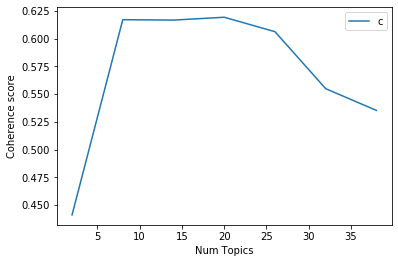

In [27]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [28]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4411
Num Topics = 8  has Coherence Value of 0.6171
Num Topics = 14  has Coherence Value of 0.6168
Num Topics = 20  has Coherence Value of 0.6193
Num Topics = 26  has Coherence Value of 0.6063
Num Topics = 32  has Coherence Value of 0.5549
Num Topics = 38  has Coherence Value of 0.5353


In [29]:
# Select the model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=True)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.046*"drive" + 0.033*"make" + 0.028*"day" + 0.019*"back" + 0.015*"enjoy" + '
  '0.015*"give" + 0.015*"people" + 0.014*"live" + 0.014*"hope" + 0.014*"long"'),
 (1,
  '0.035*"make" + 0.031*"series" + 0.024*"model" + 0.023*"people" + '
  '0.018*"big" + 0.016*"agree" + 0.015*"cool" + 0.014*"call" + 0.013*"design" '
  '+ 0.013*"guess"'),
 (2,
  '0.036*"drive" + 0.023*"sport" + 0.022*"sound" + 0.019*"fun" + 0.017*"power" '
  '+ 0.017*"manual" + 0.015*"bit" + 0.014*"performance" + 0.013*"option" + '
  '0.012*"tune"'),
 (3,
  '0.054*"year" + 0.051*"buy" + 0.033*"find" + 0.020*"sell" + 0.018*"price" + '
  '0.018*"work" + 0.017*"end" + 0.016*"money" + 0.016*"http" + 0.015*"pay"'),
 (4,
  '0.054*"wheel" + 0.035*"color" + 0.028*"front" + 0.026*"black" + '
  '0.021*"tire" + 0.018*"rear" + 0.018*"put" + 0.014*"paint" + 0.014*"set" + '
  '0.013*"badge"'),
 (5,
  '0.035*"engine" + 0.030*"mile" + 0.024*"part" + 0.021*"issue" + '
  '0.019*"change" + 0.017*"replace" + 0.017*"run" + 0.015*"check"

## Finding the dominant topic in each sentence

In [30]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.1682,"engine, mile, part, issue, change, replace, ru...","Roughly 175mph, as calculated by my USDM calcu..."
1,1,2.0,0.1568,"drive, sport, sound, fun, power, manual, bit, ...",It's ok if you don't value your own life enoug...
2,2,5.0,0.1500,"engine, mile, part, issue, change, replace, ru...",Must be a dyno. The oil temp guage looks susp...
3,3,7.0,0.1422,"post, manual_review, low, message, moderator, ...",[deleted]
4,4,2.0,0.1595,"drive, sport, sound, fun, power, manual, bit, ...",I've only ever gone that speed once in the hig...
5,5,0.0,0.1250,"drive, make, day, back, enjoy, give, people, l...",Nice!
6,6,7.0,0.1422,"post, manual_review, low, message, moderator, ...",[deleted]
7,7,0.0,0.1500,"drive, make, day, back, enjoy, give, people, l...",~262 feet per second. One second to react to s...
8,8,0.0,0.1422,"drive, make, day, back, enjoy, give, people, l...",Buddy I was the only one on the road and I am ...
9,9,3.0,0.1334,"year, buy, find, sell, price, work, end, money...",My guy 🥰


## Find the most representative document for each topic

In [31]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.4424,"drive, make, day, back, enjoy, give, people, l...","I bought a BMW 3 weeks ago. Ever since then, I..."
1,1.0,0.4774,"make, series, model, people, big, agree, cool,...",The whole beemer vs bimmer thing originated wh...
2,2.0,0.5145,"drive, sport, sound, fun, power, manual, bit, ...","Sorta true, sorta not. It depends on if the a..."
3,3.0,0.5089,"year, buy, find, sell, price, work, end, money...","I didn't say all, I said **most**. Statistica..."
4,4.0,0.5296,"wheel, color, front, black, tire, rear, put, p...",ha. Its a repost of a repost of a repost of a...


## Topic distribution across documents

In [32]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics[:20]

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,5.0,"engine, mile, part, issue, change, replace, ru...",13052.0,0.2549
1.0,2.0,"drive, sport, sound, fun, power, manual, bit, ...",6838.0,0.1335
2.0,5.0,"engine, mile, part, issue, change, replace, ru...",5387.0,0.1052
3.0,7.0,"post, manual_review, low, message, moderator, ...",5443.0,0.1063
4.0,2.0,"drive, sport, sound, fun, power, manual, bit, ...",7401.0,0.1445
5.0,0.0,"drive, make, day, back, enjoy, give, people, l...",4684.0,0.0915
6.0,7.0,"post, manual_review, low, message, moderator, ...",4858.0,0.0949
7.0,0.0,"drive, make, day, back, enjoy, give, people, l...",3548.0,0.0693
8.0,0.0,"drive, make, day, back, enjoy, give, people, l...",NaN,NaN
9.0,3.0,"year, buy, find, sell, price, work, end, money...",NaN,NaN
